In [22]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import random
#from data import Drones, Clients


In [23]:
#DATASET 
#Here we create the dataset
#Initialize
class Drones():
    def __init__(self, name, maxspeed, maxpayload, number_of_drones):
        self.name = name
        self.maxspeed = maxspeed
        self.maxpayload = maxpayload
        self.number_of_drones = number_of_drones

class Clients():
    numeber_of_clients = 0
    def __init__(self, number, x_coord, y_coord, demand):
        self.number = number
        self.x_coord = x_coord
        self.y_coord = y_coord
        self.demand = demand
        Clients.numeber_of_clients += 1

<class 'list'>
Set parameter TimeLimit to value 100
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 482 rows, 341 columns and 1890 nonzeros
Model fingerprint: 0x83f11681
Variable types: 131 continuous, 210 integer (210 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 120 rows and 11 columns
Presolve time: 0.04s
Presolved: 362 rows, 330 columns, 3045 nonzeros
Variable types: 130 continuous, 200 integer (200 binary)

Root relaxation: objective 1.146545e+03, 194 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1146.54474    0   18          - 1146.54474      -     -    0s
     0     0 1232.48

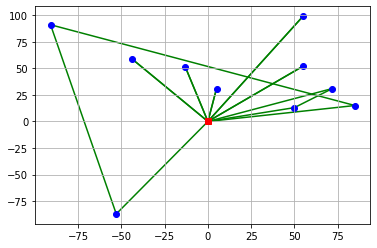

In [24]:

#Initialization
rnd = np.random
rnd.seed(0)


#Definitions

def solve_VRP(drones,clients_list,time_limit):
    # Basic problem variables
    n = Clients.numeber_of_clients # nodes
    clients = [ i for i in range(1,n+1)]
    nodes = [0]+clients
    N_N_0 = [(i,j) for i in nodes for j in clients if i!=j]
    xc = [0]+[xc.x_coord for xc in clients_list] # customer x locations
    yc = [0]+[yc.y_coord for yc in clients_list] #rnd.rand(n-1)*100 # customer y locations
    print(type(xc))
    T = time_limit # [s] total delivery duration

    # Drone parameters
    M = drones.number_of_drones # Number of drones
    K = 100 # upper bound payload weight
    v = drones.maxspeed # drone speed [m/s]
    Q = drones.maxpayload# max drone payload [kg] 

    # Decision variables
    arcs = [(i,j) for i in nodes for j in nodes if i!=j] # fully connected links
    sigma_var = [(i,j) for i in nodes[1:] for j in nodes[1:]] # going through depot
    y = arcs # payload weight between paths
    t = [i for i in nodes] # time at node i
    a = [i for i in clients] # time between node i and depot

    # Costs
    s = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in arcs} # euclidean distances
    D = {i.number: i.demand for i in clients_list}# demand of client rnd.randint(1,5)


    ### Creating the Model ###
    m = gp.Model('CVRP')

    # Adding decision variables
    x = m.addVars(arcs,vtype = GRB.BINARY,name='x') # x = arcs 
    sigma = m.addVars(sigma_var,vtype = GRB.BINARY,name='sigma') 
    y = m.addVars(y,vtype = GRB.CONTINUOUS,name='y')
    t = m.addVars(t,vtype = GRB.CONTINUOUS,name='t')
    a = m.addVars(a,vtype = GRB.CONTINUOUS,name='a')

    # Objective function
    m.setObjective(gp.quicksum(s[i,j]*x[i,j] for i,j in arcs),GRB.MINIMIZE)

    # Constraints
    m.addConstrs(gp.quicksum(x[i,j] for j in nodes if j!= i) == 1 for i in clients) # (4a)
    m.addConstrs(gp.quicksum(x[i,j] for j in nodes if j!= i)-gp.quicksum(x[j,i] for j in nodes if j!= i)== 0 for i in nodes ) #(4b)
    #Reusability Constrains
    m.addConstrs(gp.quicksum(sigma[i,j] for j in clients) <= x[i,0] for i in clients) # (5a)
    m.addConstrs(gp.quicksum(sigma[j,i] for j in clients) <= x[0,i] for i in clients) # (5b)
    m.addConstr(gp.quicksum(x[0,i] for i in clients) - gp.quicksum(sigma[i,j] for i,j in sigma_var if i!=j) <= M) # (5c)
    #Demand Contrains
    m.addConstrs(gp.quicksum(y[j,i] for j in nodes if j!=i) - gp.quicksum(y[i,j] for j in nodes if j!=i)==D[i] for i in clients) # (6a)
    m.addConstrs(y[i,j] <= K*x[i,j] for i,j in arcs if i!=j) # (6b)
    #Time Constrains
    m.addConstrs(t[i] - t[j] + s[i,j]/v <= K* (1-x[i,j]) for i,j in N_N_0 if i!=j) # (7a)
    m.addConstrs(t[i] - a[i] + s[i,0]/v <= K * (1 - x[i,0]) for i in clients) # (7b)
    m.addConstrs(a[i] - t[j] + s[0,j]/v <= K * (1 - sigma[i,j]) for i,j in sigma_var if i!=j) # (7c)
    m.addConstrs(t[i] <= T  for i in clients) # (7d)  and (7e) CHECK THIS CONSTRAINT
    #
    m.addConstrs(y[i,j] <= Q * x[i,j] for i,j in arcs if i!=j) #(8a)


    m.Params.timeLimit = 100 #[s]
    m.optimize()

    #Plotting
    active_arcs = [a for a in arcs if x[a].x > 0.99]

    for i, j in active_arcs:
        plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', zorder=0)
    plt.plot(xc[0], yc[0], c='r', marker='s')
    plt.scatter(xc[1:], yc[1:], c='b')
    plt.grid()
    plt.show()


#SAMPLE DATASET

drone1 = Drones("Amazon Drone", 10, 5, 5)#(name, maxspeed, maxpayload, number_of_drones)

client_list = []
for i in range(1,11):
    x_cord = random.sample(range(-100,100),1)[0]
    y_cord = random.sample(range(-100,100),1)[0]
    client = Clients(i, x_cord,y_cord, rnd.randint(1,5))
    client_list.append(client)

T = 60 # [s] total delivery duration



if __name__== "__main__":
    solve_VRP(drone1,client_list, T)